#  Quora Duplicate qns
Can you identify question pairs that have the same intent?

About Dataset
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

In [1]:
# pip install contractions

In [2]:
# pip install --upgrade nltk

In [3]:
# pip install --upgrade tensorflow

In [4]:
PYTHONHASHSEED=0
import random as python_random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Dense, LSTM, Embedding, Lambda, InputLayer, Bidirectional, Dropout 
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.callbacks import EarlyStopping

from collections import Counter, defaultdict
import contractions
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords

np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

In [5]:
# nltk.download('punkt')

In [6]:
# nltk.download('stopwords')

# Import Data

In [7]:
quora = pd.read_csv("quora.csv")
quora.head()

,Unnamed: 0,index,id,qid1,qid2,question1,question2,is_duplicate
0,0,8067,8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,0
1,1,368101,368101,12736,104117,What are some of the best side dishes for crab...,What are some good side dishes for buffalo chi...,0
2,2,70497,70497,121486,121487,Which is more advisable and better material fo...,What is the best server setup for buddypress?,0
3,3,226567,226567,254474,258192,How do I improve logical programming skills?,How can I improve my logical skills for progra...,1
4,4,73186,73186,48103,3062,How close we are to see 3rd world war?,How close is a World War III?,1


In [8]:
quora.shape

(100000, 8)

In [9]:
quora.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Unnamed: 0    100000 non-null  int64 
 1   index         100000 non-null  int64 
 2   id            100000 non-null  int64 
 3   qid1          100000 non-null  int64 
 4   qid2          100000 non-null  int64 
 5   question1     100000 non-null  object
 6   question2     100000 non-null  object
 7   is_duplicate  100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


In [10]:
for col in quora.select_dtypes("int64").columns:
    print(col, quora[col].nunique())

Unnamed: 0 100000
index 100000
id 100000
qid1 87035
qid2 87347
is_duplicate 2


In [11]:
print(quora.qid1.value_counts()[:10])
print()
print(quora.qid2.value_counts()[:10])

8461     18
21712    16
38362    15
1749     14
4951     13
159      13
8353     12
9006     12
35043    12
6799     12
Name: qid1, dtype: int64

2559     29
4044     26
30782    23
17978    17
28764    17
2561     17
9262     14
30647    14
691      14
20542    13
Name: qid2, dtype: int64


In [12]:
quora.is_duplicate.value_counts(1)

0    0.62879
1    0.37121
Name: is_duplicate, dtype: float64

# Data Preprocessing
## Split data

In [13]:
y = quora.is_duplicate
X = quora[["question1", "question2"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.85, random_state = 80,stratify = y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size = 0.5, random_state = 11,stratify = y_test)
print(y_train.shape, y_val.shape, y_test.shape)

(85000,) (7500,) (7500,)


In [14]:
X_train.head()

,question1,question2
77536,"How can I use ""Thus far"" in a formal writing?",What are the rules to be followed in formal em...
66062,What is the average download rate (not CTR) of...,What is the cost per install of iOS app in Fac...
45903,How do I recover my lost Gmail password if I d...,How do I reset my Gmail password when I don't ...
29329,What are common required and elective courses ...,What are common required and elective courses ...
1156,Why was The Nobel prize winning scientist Jame...,"Is it true that ""Black People are Less Intelli..."


In [15]:
X_test.head()

,question1,question2
73762,How do I loose weight fast?,How do I lose weight faster?
97642,How can I prepare for the World Scholar’s Cup?,How does winning the world scholar's cup help?
43796,What is the easy way to make money online?,How do you make money online?
76120,"What are the best answers for: ""in 150 charact...",What was the first thing you did after you los...
39879,Are Nigerians racists?,Are any nigerians white?


## Pre-process text

In [16]:
stopword_list = stopwords.words("english")
np.array(stopword_list)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [17]:
stopword_list = set([
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'between', 'into',
       'again', 'further', 'then', 'once', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will',
       'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll',
       'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn',
       "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't",
       'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma',
       'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",
       'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't",
       'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
])

In [18]:
def fix_contractions(text):    # expand contraction
    return contractions.fix(text)

def remove_punctuation(text):   # remove punctuations
    return re.sub(r"[^\w\d\s]+", '', text)

def tokenize(text):   # tokenize
    return word_tokenize(text)

_stemmer = PorterStemmer()
def stemmer(tokens):    # stemming
    return [_stemmer.stem(word, to_lowercase = True) for word in tokens ]

def remove_stopwords(tokens):   # remove stopwords
    return " ".join([token for token in tokens if token not in stopword_list])

In [19]:
sample = "What's going on at 1234 Carrier Dr? He can't concentrate on his assignment!!"
print("original:", sample)

t2 = fix_contractions(sample)
print("\nremove contraction:",t2)

t3 = remove_punctuation(t2)
print("\nremove punctuation:",t3)

t4 = tokenize(t3)
print("\ntokenize:", t4)

t5 = stemmer(t4)
print("\nstemming:", t5)

t6 = remove_stopwords(t5)
print("\nremove stopwords:", t6)

original: What's going on at 1234 Carrier Dr? He can't concentrate on his assignment!!

remove contraction: What is going on at 1234 Carrier Dr? He cannot concentrate on his assignment!!

remove punctuation: What is going on at 1234 Carrier Dr He cannot concentrate on his assignment

tokenize: ['What', 'is', 'going', 'on', 'at', '1234', 'Carrier', 'Dr', 'He', 'can', 'not', 'concentrate', 'on', 'his', 'assignment']

stemming: ['what', 'is', 'go', 'on', 'at', '1234', 'carrier', 'dr', 'he', 'can', 'not', 'concentr', 'on', 'hi', 'assign']

remove stopwords: what go on 1234 carrier dr he not concentr on hi assign


In [20]:
def process_text(text):
    text = fix_contractions(text)
    text = remove_punctuation(text)
    text = tokenize(text)
    text = stemmer(text)
    return remove_stopwords(text)

In [21]:
def process_questions(X):
    X.question1 = X.question1.apply(process_text)
    X.question2 = X.question2.apply(process_text)
    return X

In [22]:
X_train.head()

,question1,question2
77536,"How can I use ""Thus far"" in a formal writing?",What are the rules to be followed in formal em...
66062,What is the average download rate (not CTR) of...,What is the cost per install of iOS app in Fac...
45903,How do I recover my lost Gmail password if I d...,How do I reset my Gmail password when I don't ...
29329,What are common required and elective courses ...,What are common required and elective courses ...
1156,Why was The Nobel prize winning scientist Jame...,"Is it true that ""Black People are Less Intelli..."


In [23]:
X_train = process_questions(X_train)
X_val = process_questions(X_val)
X_test = process_questions(X_test)

In [24]:
X_train.head()

,question1,question2
77536,how i use thu far in formal write,what rule to follow in formal email write i ge...
66062,what averag download rate not ctr mobil ad app...,what cost per instal io app in facebook new mo...
45903,how i recov my lost gmail password i not same ...,how i reset my gmail password when i not acces...
29329,what common requir elect cours in music,what common requir elect cours in theolog
1156,whi wa nobel prize win scientist jame watson s...,it true black peopl less intellig onc said dr ...


## Vocabulary

In [25]:
q1_words = [word for question in X_train.question1.values for word in question.split(" ")]
q2_words = [word for question in X_train.question2.values for word in question.split(" ")]
unique_words = Counter(q1_words + q2_words) 
print("the number of unique words in training set:", len(unique_words))

the number of unique words in training set: 37176


In [26]:
print("1st most frequent word:", unique_words.most_common(1)[-1])
print("6000th most frequent word:", unique_words.most_common(6000)[-1])

1st most frequent word: ('what', 68078)
6000th most frequent word: ('xml', 13)


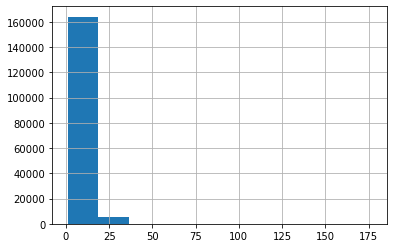

In [27]:
q1_sequence_len = [len(question.split(" ")) for question in X_train.question1.values ]
q2_sequence_len = [len(question.split(" ")) for question in X_train.question2.values ]
pd.Series(q1_sequence_len + q2_sequence_len).hist();

In [28]:
print("95% of the sequences with the length <=", np.quantile(q1_sequence_len + q2_sequence_len, 0.95))

95% of the sequences with the length <= 17.0


In [29]:
VOCAB_SIZE = 6000
MAX_SEQUENCE_LEN = 17

# A preprocessing layer which maps text features to integer sequences
text_vector = TextVectorization(
    max_tokens=VOCAB_SIZE,
    standardize=None,
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LEN,
    pad_to_max_tokens=False)

text_vector.adapt(pd.concat([X_train.question1, X_train.question2], axis = 0))
text_vector.vocabulary_size()

6000

In [30]:
X_train.question2.values[0]

'what rule to follow in formal email write i get replica'

In [31]:
text_vector(X_train.question2.values[0])

<tf.Tensor: shape=(17,), dtype=int64, numpy=
array([   2,  784,    5,  212,    6, 2295,  303,  154,    3,   14,    1,
          0,    0,    0,    0,    0,    0], dtype=int64)>

In [32]:
def convert_text_to_sequence(X):
    return text_vector(X.question1.values), text_vector(X.question2.values)
    
X_train_q1, X_train_q2 = convert_text_to_sequence(X_train)
X_val_q1, X_val_q2 = convert_text_to_sequence(X_val)
X_test_q1, X_test_q2 = convert_text_to_sequence(X_test)

In [33]:
X_train_q1[:3]

<tf.Tensor: shape=(3, 17), dtype=int64, numpy=
array([[   4,    3,   22, 5774, 1103,    6, 2295,  154,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   2,  234,  265,  366,   15,    1,  219,  694,  128,    6,  771,
         128,    1,  189,    0,    0,    0],
       [   4,    3,  550,   10,  634,  407,  275,    3,   15,  217,  100,
          15,  902, 1151,  303,    0,    0]], dtype=int64)>

In [34]:
text_vector.get_vocabulary()[:10]

['', '[UNK]', 'what', 'i', 'how', 'to', 'in', 'you', 'whi', 'it']

# Model Building

In [35]:
def history_plot(history):
    plt.figure(figsize = (15,5));
    
    ax1 = plt.subplot(121);
    ax1.plot(history["loss"], color = 'r', marker = 'o', label = "Train Loss");
    ax1.plot(history["val_loss"], color = 'b',marker = 'o', label = "Val Loss");
    plt.legend(loc="best");
    
    ax2 = plt.subplot(122);    
    ax2.plot(history["accuracy"], color = 'r', marker = 'o', label = "Train Accuracy");
    ax2.plot(history["val_accuracy"], color = 'b', marker = 'o', label = "Val Accuracy");    
    plt.legend(loc="best");

In [36]:
WORD_EMBEDDING_DIM = 32
LEARNING_RATE = 0.0001

def normalized_by_column(X):
    return X / tf.norm(X, axis = 1, keepdims=True)  # normalized by column

def cosine_similarity(v):
    v1, v2 = v
    v1, v2 = normalized_by_column(v1), normalized_by_column(v2)
    cos = tf.reduce_sum(v1 * v2, axis = -1,keepdims= True)
    return cos   # output -1 ~ 1

def Siamese():
    Input1 = Input(shape=(MAX_SEQUENCE_LEN, ))   # used to instantiate a Keras tensor.
    Input2 = Input(shape=(MAX_SEQUENCE_LEN, ))
    
    base_net = Sequential([
        Embedding(input_dim = VOCAB_SIZE, output_dim = WORD_EMBEDDING_DIM, input_length = MAX_SEQUENCE_LEN),
        Bidirectional(LSTM(12, dropout = 0.4, return_sequences=True)),
        Bidirectional(LSTM(12, dropout = 0.5, return_sequences=False)),
        Dense(8, activation = 'elu'),
    ])

    v1 = base_net(Input1)  # convert tensor to numpy array
    v2 = base_net(Input2)

    distance = Lambda(function = cosine_similarity, name = "similarity")([v1, v2])
    out = Dense(1, activation = 'sigmoid')(distance)
    model = Model(inputs = [Input1, Input2], outputs = out)    
    model.compile(loss="binary_crossentropy", 
                  optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), 
                  metrics=["accuracy"])
    
    model.summary()
    return model

In [37]:
model = Siamese()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 8)            200072      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 similarity (Lambda)            (None, 1)            0           ['sequential[0][0]',         

In [38]:
BATCH_SIZE = 256
es = EarlyStopping(patience=5, restore_best_weights=True)
EPOCHS = 100

history = model.fit(x = [ X_train_q1, X_train_q2 ],
                    y = y_train,  
                    batch_size = BATCH_SIZE, 
                    validation_data = ([ X_val_q1, X_val_q2 ], y_val), 
                    validation_batch_size = BATCH_SIZE,
                    callbacks=[es],                    
                    epochs = EPOCHS)

Epoch 1/100
333/333 [==============================] - 30s 39ms/step - loss: 0.7216 - accuracy: 0.4958 - val_loss: 0.7567 - val_accuracy: 0.4803
Epoch 2/100
333/333 [==============================] - 9s 26ms/step - loss: 0.6979 - accuracy: 0.5275 - val_loss: 0.7391 - val_accuracy: 0.4863
Epoch 3/100
333/333 [==============================] - 9s 27ms/step - loss: 0.6852 - accuracy: 0.5519 - val_loss: 0.7220 - val_accuracy: 0.5083
Epoch 4/100
333/333 [==============================] - 8s 25ms/step - loss: 0.6745 - accuracy: 0.5717 - val_loss: 0.7103 - val_accuracy: 0.5184
Epoch 5/100
333/333 [==============================] - 9s 26ms/step - loss: 0.6651 - accuracy: 0.5886 - val_loss: 0.7018 - val_accuracy: 0.5325
Epoch 6/100
333/333 [==============================] - 8s 25ms/step - loss: 0.6572 - accuracy: 0.6059 - val_loss: 0.6910 - val_accuracy: 0.5427
Epoch 7/100
333/333 [==============================] - 10s 29ms/step - loss: 0.6488 - accuracy: 0.6215 - val_loss: 0.6830 - val_accurac

333/333 [==============================] - 11s 33ms/step - loss: 0.4434 - accuracy: 0.8122 - val_loss: 0.5663 - val_accuracy: 0.6852
Epoch 58/100
333/333 [==============================] - 12s 35ms/step - loss: 0.4409 - accuracy: 0.8141 - val_loss: 0.5653 - val_accuracy: 0.6857
Epoch 59/100
333/333 [==============================] - 11s 33ms/step - loss: 0.4387 - accuracy: 0.8150 - val_loss: 0.5654 - val_accuracy: 0.6849
Epoch 60/100
333/333 [==============================] - 11s 33ms/step - loss: 0.4357 - accuracy: 0.8164 - val_loss: 0.5681 - val_accuracy: 0.6795
Epoch 61/100
333/333 [==============================] - 11s 34ms/step - loss: 0.4337 - accuracy: 0.8156 - val_loss: 0.5644 - val_accuracy: 0.6857
Epoch 62/100
333/333 [==============================] - 11s 33ms/step - loss: 0.4326 - accuracy: 0.8158 - val_loss: 0.5638 - val_accuracy: 0.6835
Epoch 63/100
333/333 [==============================] - 12s 35ms/step - loss: 0.4302 - accuracy: 0.8162 - val_loss: 0.5666 - val_accuracy

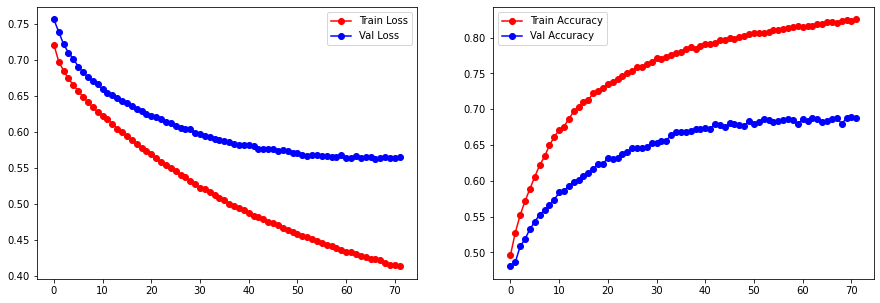

In [39]:
history_plot(history.history)

In [40]:
print("Train:")
model.evaluate([X_train_q1, X_train_q2], y_train)
print("Validation:")
model.evaluate([X_val_q1, X_val_q2], y_val)
print("Test:")
model.evaluate([X_test_q1, X_test_q2], y_test)

Train:
2657/2657 [==============================] - 11s 4ms/step - loss: 0.4041 - accuracy: 0.8283
Validation:
235/235 [==============================] - 1s 4ms/step - loss: 0.5629 - accuracy: 0.6860
Test:
235/235 [==============================] - 1s 4ms/step - loss: 0.5670 - accuracy: 0.6875


[0.5669995546340942, 0.6874666810035706]

In [41]:
THRESHOLD = 0.5

y_pred = model.predict(x = [X_test_q1, X_test_q2]).flatten()
y_label = (y_pred > THRESHOLD)
print("accuracy:", np.sum(y_label == y_test) / len(y_label))

235/235 [==============================] - 6s 4ms/step
accuracy: 0.6874666666666667


Recall: 0.8433908045977011
Precision: 0.5516917293233082


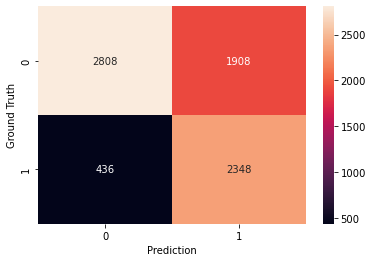

In [42]:
cm = confusion_matrix(y_test, y_label)
sns.heatmap(pd.DataFrame(cm, index = [0,1], columns = [0,1]), annot = True, fmt = 'd');
plt.xlabel("Prediction");
plt.ylabel("Ground Truth");
print("Recall:", recall_score(y_test, y_label))
print("Precision:", precision_score(y_test, y_label))

In [43]:
# idx = (y_label != y_test)
# error_samples = pd.concat([X_test[idx], y_test[idx], pd.Series(y_pred[idx], index = y_test[idx].index, name = "pred")], 
#           axis = 1).sample(20, random_state = 5)
# error_samples

In [44]:
# for i in error_samples.index:
#     print(i, quora.loc[i, ["question1","question2", "is_duplicate"]].values)
#     print()